In [1]:
# Transformers installation
# ! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Fine-tune a pretrained model

There are significant benefits to using a pretrained model. It reduces computation costs, your carbon footprint, and allows you to use state-of-the-art models without having to train one from scratch. 🤗 Transformers provides access to thousands of pretrained models for a wide range of tasks. When you use a pretrained model, you train it on a dataset specific to your task. This is known as fine-tuning, an incredibly powerful training technique. In this tutorial, you will fine-tune a pretrained model with a deep learning framework of your choice:

* Fine-tune a pretrained model with 🤗 Transformers [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer).
* Fine-tune a pretrained model in TensorFlow with Keras.
* Fine-tune a pretrained model in native PyTorch.

<a id='data-processing'></a>

## Train in native PyTorch

Create a `DataLoader` for your training and test datasets so you can iterate over batches of data:

You will need to install (via pip3): gensim, nltk.
You will also need to run (with python3 in terminal)
>>>import nltk
>>>nltk.download('stopwords')
>>>nltk.download('wordnet')
>>>nltk.download('omw-1.4')

In [2]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm
from datasets import Dataset
import torch
import pyarrow as pa
import pandas as pd
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt



In [3]:
with open('stock_data.csv', encoding='utf8') as csvfile:
    df = pd.read_csv(csvfile, delimiter=',')

df.dropna(axis=0, how='any', inplace=True)                         # Excludes null-containing rows
num_positive = df['Sentiment'].value_counts()[1]

df.loc[df['Sentiment'] == -1, 'Sentiment'] = 0
num_negative = df['Sentiment'].value_counts()[0]
print(df['Sentiment'].value_counts())


1    3685
0    2106
Name: Sentiment, dtype: int64


In [4]:
# Hyperparameters
word_frequency_requirement = 0.0013*(df['Sentiment'].size) # the number of times a word has to appear to be given
# it's own encoding. All words under this limit are encoded as the same 'unknown' word.
sg = 0
# vector_size = 1000

In [5]:
# Regex removal of various undesirable parts of a tweet
def clean_tweet(tweet):
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) # Twitter handle removal
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet) # URL removal
  tweet = re.sub(r"[']", "", tweet) # Apostrophe removal
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet) # Remove symbols that are not alphabetic or sentence endings
  tweet = re.sub(r"([^a-zA-Z])", r" \1 ", tweet) # Places spaces around sentence endings,
  # so they are encoded as their own words, rather than being lumped in with other words.
  tweet = re.sub(r" +", ' ', tweet) # Excess whitespace removal
  tweet = tweet.lower() # Send tweet to lowercase
  return tweet

In [6]:
# Prepare word lemmatizer and stopwords list for sanitisation
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))

def sanitise(tweet):
    tweet = clean_tweet(tweet)
    tweet = filter(lambda w: w not in stops, tweet.strip().split()) # Remove stopwords
    return " ".join(list(map(lemmatizer.lemmatize, tweet))) # Lemmatize words.

# Hyperparameters
train_proportion = 0.80
batch_size = 8

print(type(df))
df['Text'] = df['Text'].map(sanitise)
max_tweet_length = max(len(x) for x in df['Text'])
print(max_tweet_length)
train_df = df.sample(frac = 0.8)
eval_df = df.drop(train_df.index)
test_size = len(eval_df['Sentiment'])

### convert to Huggingface dataset
train_dataset = Dataset(pa.Table.from_pandas(train_df))
eval_dataset = Dataset(pa.Table.from_pandas(eval_df))


<class 'pandas.core.frame.DataFrame'>
131


In [7]:

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True)


tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_train_datasets = tokenized_train_datasets.remove_columns(["Text", "__index_level_0__"])
tokenized_train_datasets = tokenized_train_datasets.rename_column("Sentiment", "labels")
tokenized_train_datasets.set_format("torch")

tokenized_eval_datasets = eval_dataset.map(tokenize_function, batched=True)
tokenized_eval_datasets = tokenized_eval_datasets.remove_columns(["Text", "__index_level_0__"])
tokenized_eval_datasets = tokenized_eval_datasets.rename_column("Sentiment", "labels")
tokenized_eval_datasets.set_format("torch")

train_dataloader = DataLoader(dataset = tokenized_train_datasets, batch_size = batch_size, shuffle = True)
eval_dataloader = DataLoader(dataset = tokenized_eval_datasets, batch_size = batch_size, shuffle = True)


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [8]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [9]:
#device = torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(torch.cuda.is_available())
model.to(device)


True


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Optimizer and learning rate scheduler

Create an optimizer and learning rate scheduler to fine-tune the model. Let's use the [`AdamW`](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) optimizer from PyTorch:

In [10]:
optimizer = AdamW(model.parameters(), lr=5e-5)

Create the default learning rate scheduler from [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer):

In [11]:
num_epochs = 100
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

<Tip>

Get free access to a cloud GPU if you don't have one with a hosted notebook like [Colaboratory](https://colab.research.google.com/) or [SageMaker StudioLab](https://studiolab.sagemaker.aws/).

</Tip>

Great, now you are ready to train! 🥳

### Training loop

In [12]:
plot_loss = []
plot_correct = []

model.train()
for epoch in range(num_epochs):
    batch_progress_bar = tqdm(total=len(train_dataloader))
    batch_progress_bar.set_description("Progress through epoch")
    epoch_loss = 0.
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        epoch_loss += loss.data.item()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        batch_progress_bar.update(1)
    epoch_loss = epoch_loss/len(train_dataloader)

    batch_progress_bar.close()

    eval_batch_progress_bar = tqdm(total=len(eval_dataloader))
    eval_batch_progress_bar.set_description("Epoch Accuracy evaluation progress")
    correct = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            output = model(**batch)
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        correct += torch.sum(predictions==batch["labels"]).data.item()
        eval_batch_progress_bar.update(1)

    eval_batch_progress_bar.close()

    accuracy = correct/test_size*100
    print("Epoch: %02d, Loss: %f, Accuracy: %.2f%%" % (epoch+1, epoch_loss, accuracy) )

    plot_loss.append(epoch_loss)
    plot_correct.append(accuracy)
    

Epoch Accuracy evaluation progress: 100%|██████████| 145/145 [01:09<00:00,  2.08it/s]


Epoch: 01, Loss: 0.645614, Accuracy: 63.99%


Progress through epoch:   5%|▍         | 28/580 [00:31<09:38,  1.05s/it]

KeyboardInterrupt: 

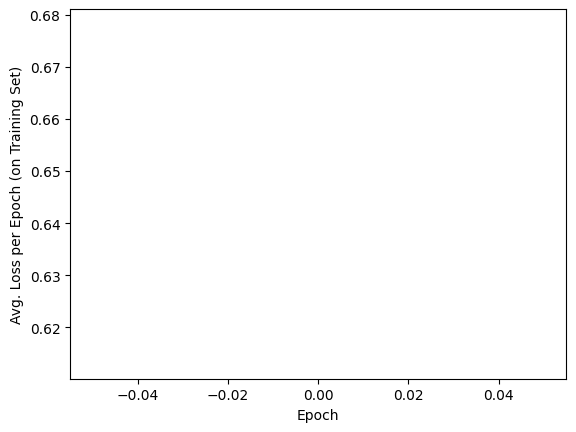

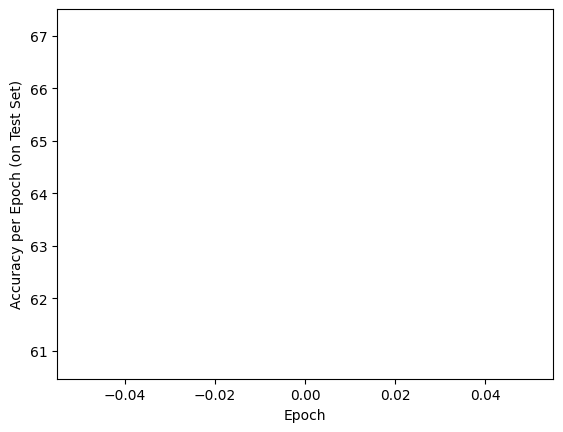

In [15]:
# Plot results
plt.plot(plot_loss)
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss per Epoch (on Training Set)')
plt.show()

plt.plot(plot_correct)
plt.xlabel('Epoch')
plt.ylabel('Accuracy per Epoch (on Test Set)')
plt.show()

## Additional resources

For more fine-tuning examples, refer to:

- [🤗 Transformers Examples](https://github.com/huggingface/transformers/tree/main/examples) includes scripts
  to train common NLP tasks in PyTorch and TensorFlow.

- [🤗 Transformers Notebooks](https://huggingface.co/docs/transformers/main/en/notebooks) contains various notebooks on how to fine-tune a model for specific tasks in PyTorch and TensorFlow.